In [1]:
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd

import numpy as np
from scipy.special import gamma, gammainc
from scipy.stats import uniform, entropy

from polydispers.stats import sz_distribution_inverse_transform
from polydispers.input_config import InputConfig, PolymerConfig, BeadTypeConfig

# Set the style to white and remove the grid
sns.set_style("white")

# Set the context with a minimum font size of 12pt
sns.set_context("paper", font_scale=1.5)

np.random.seed(42)


In [ ]:

def get_sz_chains_aa(pdi, mn, chains, toplogy="AA", masses={"A": 1}):
    config_string = f"""
    num_chains: {chains}
    mn: {mn}
    pdi: {pdi}
    box_size: 100
    output_dir: .
    seed: 42
    polymer:
      repeat_unit_topology: {toplogy}
      bond_length: 1
      bead_radius: 1
      bead_types:
    """
    for bead_type, mass in masses.items():
        config_string += f"""
        {bead_type}:
          mass: {mass}
          type_id: 1
        """

    config = InputConfig.from_string(config_string)

    r, b = sz_distribution_inverse_transform(config)

    z = 1 / (pdi - 1.0)
    hist, bin_edges = np.histogram(r, bins=20, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    sz_dist = gamma.pdf(bin_centers, a=z+1, scale=mn/chains/(z+1))
    kl_divergence = entropy(hist, sz_dist)

    return r, sz_dist, bin_centers, kl_divergence

KL Divergence: 0.015061836060277898


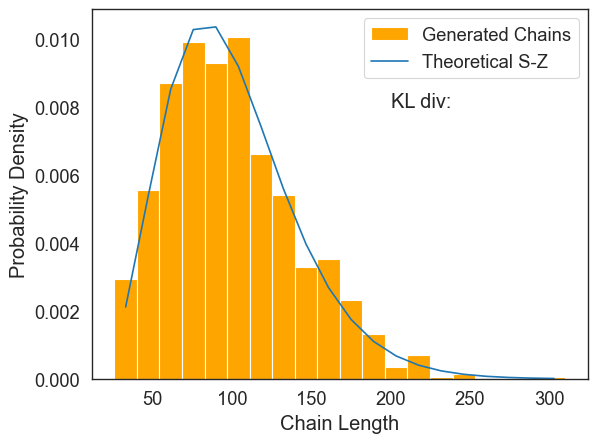

In [25]:
from scipy.stats import gamma
r,sz_dist, bin_centers, kl_divergence = get_sz_chains(1.2, 100000, 1000)
# Plot the distributions for visualization
plt.hist(r, bins=20, density=True, label="Generated Chains", color='orange')
plt.plot(bin_centers, sz_dist, label="Theoretical S-Z")

plt.xlabel("Chain Length")
plt.ylabel("Probability Density")
plt.text(200, 0.008, f"KL div: ")
plt.legend()
plt.savefig("sz_distribution.png")

print(f"KL Divergence: {kl_divergence}")

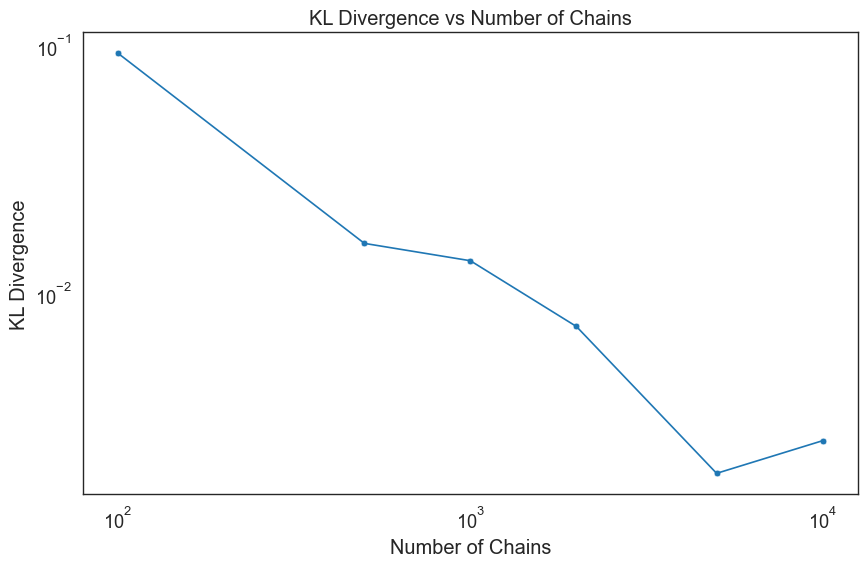

   Number of Chains  KL Divergence
0               100       0.091946
1               500       0.015834
2              1000       0.013483
3              2000       0.007336
4              5000       0.001884
5             10000       0.002549


In [31]:
# Let's analyse how the KL divergency change with the number of chains

# Parameters
pdi = 1.2
mn = 1000000
alpha = 0.5  # Schulz-Zimm parameter
n_points = 100
x = np.linspace(0, 10, n_points)

# Test different chain numbers
chain_numbers = [100, 500, 1000, 2000, 5000, 10000]
kl_divergences = []

# Calculate KL divergence for each chain number
for n_chains in chain_numbers:
    r, sz_dist, bin_centers, kl_divergence = get_sz_chains(pdi, mn, n_chains)
    kl_divergences.append(kl_divergence)

# Create DataFrame
df = pd.DataFrame({
    'Number of Chains': chain_numbers,
    'KL Divergence': kl_divergences
})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Number of Chains', y='KL Divergence')
sns.lineplot(data=df, x='Number of Chains', y='KL Divergence')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Chains')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs Number of Chains')
plt.show()

# Print numerical results
print(df)